# Alpha 2: Running BERT

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parameter as Parameter
from transformers import BertModel, BertConfig, BertTokenizer
import numpy as np
import copy
import matplotlib.pyplot as plt
from models import *

/home/ashwin/miniconda3/envs/school-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting EXP 2: Single Layer Sensitivity...
  Only Layer 0 quantized -> Similarity: 0.7876
  Only Layer 1 quantized -> Similarity: 0.6145
  Only Layer 2 quantized -> Similarity: 0.6354
  Only Layer 3 quantized -> Similarity: 0.6074
  Only Layer 4 quantized -> Similarity: 0.6115
  Only Layer 5 quantized -> Similarity: 0.6376
  Only Layer 6 quantized -> Similarity: 0.6378
  Only Layer 7 quantized -> Similarity: 0.6121
  Only Layer 8 quantized -> Similarity: 0.5684
  Only Layer 9 quantized -> Similarity: 0.6631
  Only Layer 10 quantized -> Similarity: 0.3966
  Only Layer 11 quantized -> Similarity: 0.4318


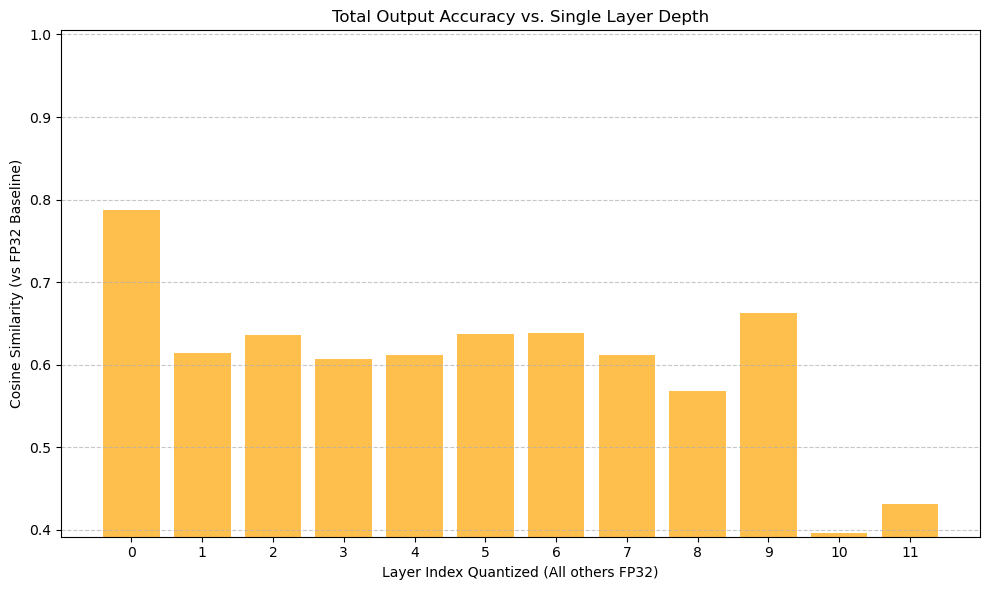

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
clean_model = BertModel.from_pretrained('bert-base-uncased').to(device)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
clean_model.eval()
inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors='pt').to(device)
with torch.no_grad():
    fp32_output = clean_model(**inputs).last_hidden_state

single_layer_similarities = []
num_layers = len(clean_model.encoder.layer)

print(f"Starting EXP 2: Single Layer Sensitivity...")

for i in range(num_layers):
    temp_model = copy.deepcopy(clean_model)
    original_layer = temp_model.encoder.layer[i].intermediate.dense
    quant_layer = QuantLinear(
        in_features=original_layer.in_features,
        out_features=original_layer.out_features,
        bias=True
    ).to(device)
    with torch.no_grad():
        quant_layer.weight.copy_(original_layer.weight)
        if original_layer.bias is not None:
            quant_layer.bias.copy_(original_layer.bias)
    temp_model.encoder.layer[i].intermediate.dense = quant_layer
    with torch.no_grad():
        quant_output = temp_model(**inputs).last_hidden_state
    score = cos(fp32_output.view(-1), quant_output.view(-1)).item()
    single_layer_similarities.append(score)
    print(f"  Only Layer {i} quantized -> Similarity: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(num_layers), single_layer_similarities, color='orange', alpha=0.7)
plt.ylim(min(single_layer_similarities) - 0.005, 1.005)
plt.title('Total Output Accuracy vs. Single Layer Depth')
plt.xlabel('Layer Index Quantized (All others FP32)')
plt.ylabel('Cosine Similarity (vs FP32 Baseline)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(num_layers))
plt.tight_layout()
plt.show()

Getting FP32 baseline...
Step 1: Profiling layer sensitivity...
  Layer 0 sensitivity score: 0.78758
  Layer 1 sensitivity score: 0.61451
  Layer 2 sensitivity score: 0.63544
  Layer 3 sensitivity score: 0.60736
  Layer 4 sensitivity score: 0.61146
  Layer 5 sensitivity score: 0.63763
  Layer 6 sensitivity score: 0.63780
  Layer 7 sensitivity score: 0.61211
  Layer 8 sensitivity score: 0.56837
  Layer 9 sensitivity score: 0.66305
  Layer 10 sensitivity score: 0.39661
  Layer 11 sensitivity score: 0.43183

Smart Order (Quantize these first): [0, 9, 6, 5, 2, 1, 7, 4, 3, 8, 11, 10]
Running cumulative loop: Smart Sort
Running cumulative loop: Naive (0-11)


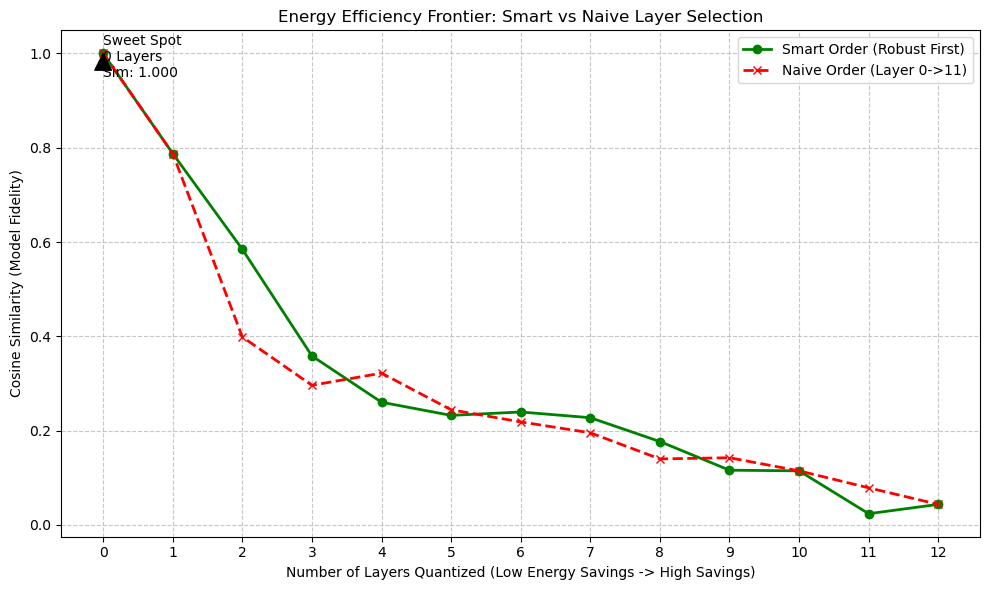

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = BertModel.from_pretrained('bert-base-uncased').to(device)
baseline_model.eval()
text = "The quick brown fox jumps over the lazy dog."
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(text, return_tensors='pt').to(device)

for i in range(num_layers):
    baseline_model.encoder.layer[i].intermediate.activation = F.relu

print("Getting FP32 baseline...")
with torch.no_grad():
    fp32_output = baseline_model(**inputs).last_hidden_state

print("Step 1: Profiling layer sensitivity...")

num_layers = len(baseline_model.encoder.layer)
layer_sensitivities = []
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

for i in range(num_layers):
    temp_model = copy.deepcopy(baseline_model)
    original_layer = temp_model.encoder.layer[i].intermediate.dense
    quant_layer = QuantLinear(
        in_features=original_layer.in_features,
        out_features=original_layer.out_features,
        bias=True
    ).to(device)
    
    with torch.no_grad():
        quant_layer.weight.copy_(original_layer.weight)
        if original_layer.bias is not None:
            quant_layer.bias.copy_(original_layer.bias)

    temp_model.encoder.layer[i].intermediate.dense = quant_layer
    with torch.no_grad():
        q_out = temp_model(**inputs).last_hidden_state
    score = cos(fp32_output.view(-1), q_out.view(-1)).item()
    layer_sensitivities.append((i, score))
    print(f"  Layer {i} sensitivity score: {score:.5f}")

sorted_by_robustness = sorted(layer_sensitivities, key=lambda x: x[1], reverse=True)
smart_order = [x[0] for x in sorted_by_robustness]
naive_order = list(range(num_layers))

print(f"\nSmart Order (Quantize these first): {smart_order}")
def run_cumulative_loop(order_indices, label):
    test_model = copy.deepcopy(baseline_model)
    accuracies = [1.0]
    
    print(f"Running cumulative loop: {label}")
    
    for i, layer_idx in enumerate(order_indices):
        orig = test_model.encoder.layer[layer_idx].intermediate.dense
        q_layer = QuantLinear(orig.in_features, orig.out_features, bias=True).to(device)
        with torch.no_grad():
            q_layer.weight.copy_(orig.weight)
            if orig.bias is not None: q_layer.bias.copy_(orig.bias)
        test_model.encoder.layer[layer_idx].intermediate.dense = q_layer
        test_model.encoder.layer[layer_idx].intermediate.activation = F.relu
        with torch.no_grad():
            out = test_model(**inputs).last_hidden_state
            
        acc = cos(fp32_output.view(-1), out.view(-1)).item()
        accuracies.append(acc)
        
    return accuracies

smart_curve = run_cumulative_loop(smart_order, "Smart Sort")
naive_curve = run_cumulative_loop(naive_order, "Naive (0-11)")

plt.figure(figsize=(10, 6))
plt.plot(range(num_layers + 1), smart_curve, 'g-o', linewidth=2, label='Smart Order (Robust First)')
plt.plot(range(num_layers + 1), naive_curve, 'r--x', linewidth=2, label='Naive Order (Layer 0->11)')


plt.title('Energy Efficiency Frontier: Smart vs Naive Layer Selection')
plt.xlabel('Number of Layers Quantized (Low Energy Savings -> High Savings)')
plt.ylabel('Cosine Similarity (Model Fidelity)')
plt.xticks(range(num_layers + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

threshold = 0.99
for i, val in enumerate(smart_curve):
    if val < threshold:
        sweet_spot_idx = i - 1
        sweet_spot_val = smart_curve[sweet_spot_idx]
        plt.annotate(f'Sweet Spot\n{sweet_spot_idx} Layers\nSim: {sweet_spot_val:.3f}',
                     xy=(sweet_spot_idx, sweet_spot_val),
                     xytext=(sweet_spot_idx, sweet_spot_val - 0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05))
        break

plt.tight_layout()
plt.show()

Candidates for Search (Top 12): [0, 9, 6, 5, 2, 1, 7, 4, 3, 8, 11, 10]
Ignoring (Too Fragile): []
Generating search space...
Total architectures to test: 4095


Searching Architectures: 100%|██████████| 4095/4095 [06:33<00:00, 10.40arch/s]



--- Optimal Combinations (Pareto Frontier) ---
Layers: 1 | Score: 0.7876 | Config: (0,)
Layers: 2 | Score: 0.5970 | Config: (0, 5)
Layers: 3 | Score: 0.4372 | Config: (0, 9, 3)
Layers: 4 | Score: 0.3877 | Config: (7, 4, 3, 8)
Layers: 5 | Score: 0.3451 | Config: (0, 6, 5, 2, 8)
Layers: 6 | Score: 0.3358 | Config: (5, 2, 1, 4, 3, 8)
Layers: 7 | Score: 0.3324 | Config: (0, 6, 5, 1, 4, 3, 8)
Layers: 8 | Score: 0.2900 | Config: (0, 6, 5, 2, 1, 4, 3, 8)
Layers: 9 | Score: 0.2305 | Config: (0, 6, 2, 1, 7, 4, 3, 8, 10)
Layers: 10 | Score: 0.1351 | Config: (0, 9, 6, 5, 2, 1, 4, 3, 8, 10)
Layers: 11 | Score: 0.0788 | Config: (0, 9, 6, 5, 2, 1, 7, 4, 3, 8, 10)
Layers: 12 | Score: 0.0437 | Config: (0, 9, 6, 5, 2, 1, 7, 4, 3, 8, 11, 10)


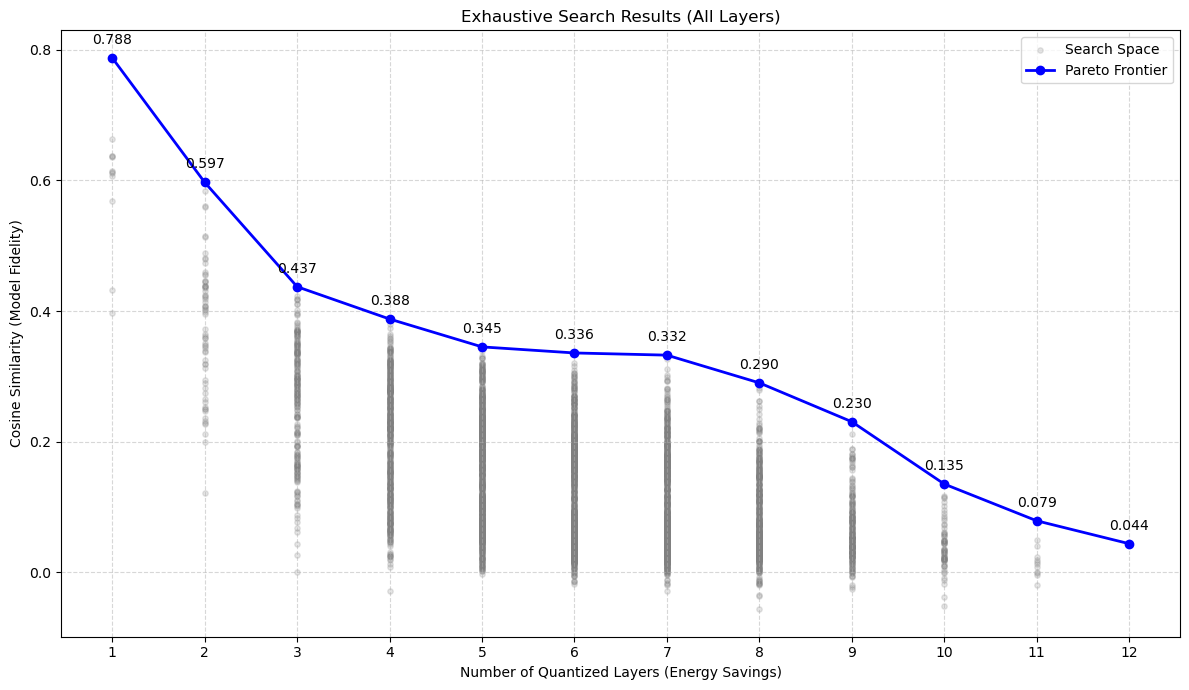

In [ ]:
import itertools
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = BertModel.from_pretrained('bert-base-uncased').to(device)
baseline_model.eval()

text = "The quick brown fox jumps over the lazy dog."
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(text, return_tensors='pt').to(device)

with torch.no_grad():
    fp32_output = baseline_model(**inputs).last_hidden_state

# i hard coded these values from the previous cell outputs
layer_scores = {
    0: 0.78758, 1: 0.61451, 2: 0.63544, 3: 0.60736, 
    4: 0.61146, 5: 0.63763, 6: 0.63780, 7: 0.61211, 
    8: 0.56837, 9: 0.66305, 10: 0.39661, 11: 0.43183
}

sorted_layers = sorted(layer_scores.items(), key=lambda x: x[1], reverse=True)

top_k = 12
candidate_indices = [x[0] for x in sorted_layers[:top_k]]
ignored_indices = [x[0] for x in sorted_layers[top_k:]]

print(f"Candidates for Search (Top {top_k}): {candidate_indices}")
print(f"Ignoring (Too Fragile): {ignored_indices}")
print("Generating search space...")
all_combinations = []
for r in range(1, top_k + 1):
    combos = list(itertools.combinations(candidate_indices, r))
    all_combinations.extend(combos)

print(f"Total architectures to test: {len(all_combinations)}")

results = [] 

for combo in tqdm(all_combinations, desc="Searching Architectures", unit="arch"):
    
    test_model = copy.deepcopy(baseline_model)
    for layer_idx in combo:
        orig = test_model.encoder.layer[layer_idx].intermediate.dense
        q_layer = QuantLinear(orig.in_features, orig.out_features, bias=True).to(device)
        with torch.no_grad():
            q_layer.weight.copy_(orig.weight)
            if orig.bias is not None: q_layer.bias.copy_(orig.bias)
        test_model.encoder.layer[layer_idx].intermediate.dense = q_layer
    with torch.no_grad():
        out = test_model(**inputs).last_hidden_state
    score = torch.nn.CosineSimilarity(dim=0)(fp32_output.view(-1), out.view(-1)).item()
    results.append({
        "num_quantized": len(combo),
        "score": score,
        "combo": combo
    })
best_per_level = {}
for r in results:
    n = r["num_quantized"]
    s = r["score"]
    if n not in best_per_level or s > best_per_level[n]["score"]:
        best_per_level[n] = r
x_all = [r["num_quantized"] for r in results]
y_all = [r["score"] for r in results]
x_best = sorted(best_per_level.keys())
y_best = [best_per_level[k]["score"] for k in x_best]

print("\n--- Optimal Combinations (Pareto Frontier) ---")
for k in x_best:
    print(f"Layers: {k} | Score: {best_per_level[k]['score']:.4f} | Config: {best_per_level[k]['combo']}")

plt.figure(figsize=(12, 7))
plt.scatter(x_all, y_all, color='gray', alpha=0.2, s=15, label='Search Space')
plt.plot(x_best, y_best, color='blue', marker='o', linewidth=2, label='Pareto Frontier')
for k, score in zip(x_best, y_best):
    plt.annotate(f"{score:.3f}", (k, score), textcoords="offset points", xytext=(0,10), ha='center')

if top_k < num_layers:
    plt.title(f'Exhaustive Search Results (Top {top_k} Candidates)')
else:
    plt.title('Exhaustive Search Results (All Layers)')
plt.xlabel('Number of Quantized Layers (Energy Savings)')
plt.ylabel('Cosine Similarity (Model Fidelity)')
plt.xticks(range(1, top_k + 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Calculating curve for: Naive Strategy...
Calculating curve for: Smart Sorted Strategy...


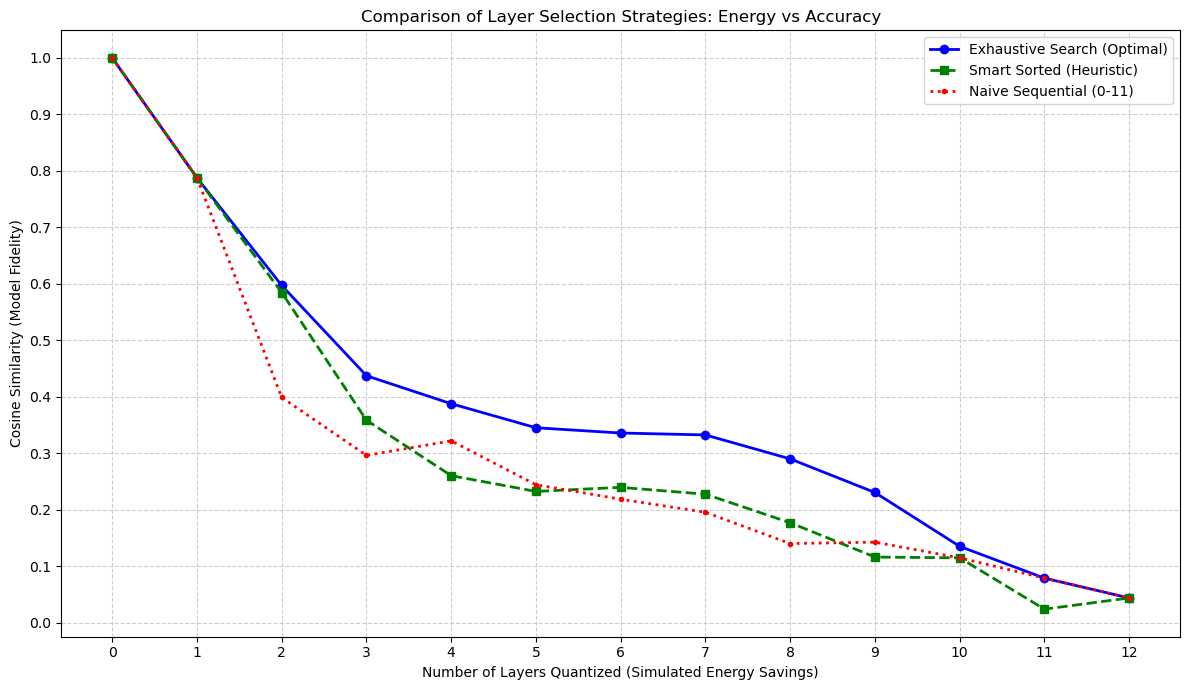

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = BertModel.from_pretrained('bert-base-uncased').to(device)
baseline_model.eval()

text = "The quick brown fox jumps over the lazy dog."
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(text, return_tensors='pt').to(device)


with torch.no_grad():
    fp32_output = baseline_model(**inputs).last_hidden_state

num_layers = len(baseline_model.encoder.layer)
exhaustive_results = {
    1: 0.7876, 2: 0.5970, 3: 0.4372, 4: 0.3877, 5: 0.3451,
    6: 0.3358, 7: 0.3324, 8: 0.2900, 9: 0.2305, 10: 0.1351, 
    11: 0.0788, 12: 0.0437
}
exhaustive_scores = [1.0] + [exhaustive_results[i] for i in range(1, 13)]
naive_order = list(range(num_layers))
smart_order = [0, 9, 6, 5, 2, 1, 7, 4, 3, 8, 11, 10]

def run_curve(order, label):
    scores = [1.0]
    test_model = copy.deepcopy(baseline_model)
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    
    print(f"Calculating curve for: {label}...")
    for layer_idx in order:
        orig = test_model.encoder.layer[layer_idx].intermediate.dense
        q_layer = QuantLinear(orig.in_features, orig.out_features, bias=True).to(device)
        with torch.no_grad():
            q_layer.weight.copy_(orig.weight)
            if orig.bias is not None: q_layer.bias.copy_(orig.bias)
        test_model.encoder.layer[layer_idx].intermediate.dense = q_layer
        with torch.no_grad():
            out = test_model(**inputs).last_hidden_state
        
        scores.append(cos(fp32_output.view(-1), out.view(-1)).item())
        
    return scores

naive_scores = run_curve(naive_order, "Naive Strategy")
smart_scores = run_curve(smart_order, "Smart Sorted Strategy")

plt.figure(figsize=(12, 7))
x_axis = range(0, num_layers + 1)
plt.plot(x_axis, exhaustive_scores, 'b-o', linewidth=2, label='Exhaustive Search (Optimal)')
plt.plot(x_axis, smart_scores, 'g--s', linewidth=2, label='Smart Sorted (Heuristic)')
plt.plot(x_axis, naive_scores, 'r:.', linewidth=2, label='Naive Sequential (0-11)')
plt.title('Comparison of Layer Selection Strategies: Energy vs Accuracy')
plt.xlabel('Number of Layers Quantized (Simulated Energy Savings)')
plt.ylabel('Cosine Similarity (Model Fidelity)')
plt.xticks(x_axis)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

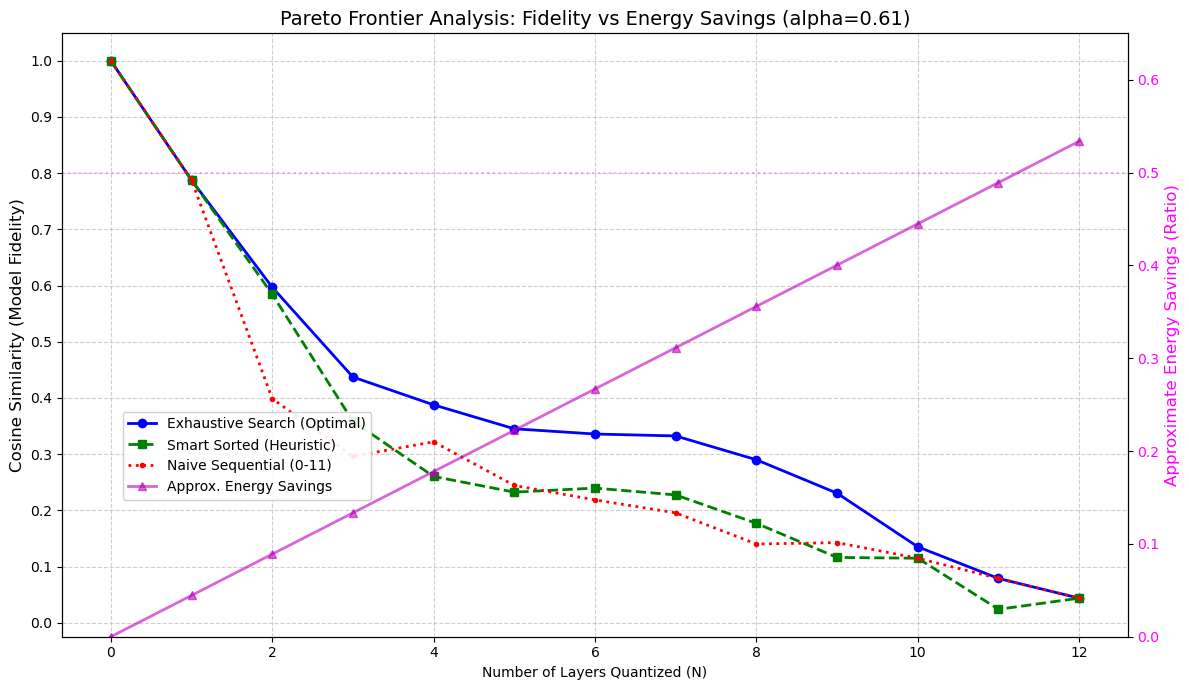

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# check project report for explanation
alpha = 0.61 

x_axis = range(0, num_layers + 1)
energy_savings = [(7 * n * alpha) / 96 for n in x_axis]
fig, ax1 = plt.subplots(figsize=(12, 7))
l1, = ax1.plot(x_axis, exhaustive_scores, 'b-o', linewidth=2, label='Exhaustive Search (Optimal)')
l2, = ax1.plot(x_axis, smart_scores, 'g--s', linewidth=2, label='Smart Sorted (Heuristic)')
l3, = ax1.plot(x_axis, naive_scores, 'r:.', linewidth=2, label='Naive Sequential (0-11)')

ax1.set_xlabel('Number of Layers Quantized (N)')
ax1.set_ylabel('Cosine Similarity (Model Fidelity)', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(True, linestyle='--', alpha=0.6)


ax2 = ax1.twinx()

l4, = ax2.plot(x_axis, energy_savings, 'm-^', linewidth=2, label='Approx. Energy Savings', alpha=0.6)

ax2.set_ylabel('Approximate Energy Savings (Ratio)', color='magenta', fontsize=12)
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.set_ylim(0, 0.65)
ax2.axhline(y=0.5, color='magenta', linestyle=':', alpha=0.3)
lines = [l1, l2, l3, l4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(0.05, 0.3), framealpha=0.9)
plt.title(f'Pareto Frontier Analysis: Fidelity vs Energy Savings (alpha={alpha})', fontsize=14)
plt.tight_layout()
plt.show()